# Medical Label Project

## Setting up

Import necessary packages and adjust settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

Read data from csv files.

In [2]:
reads = pd.read_csv('data/1345_admin_reads.csv')
results = pd.read_csv('data/1345_customer_results.csv',index_col="Case ID")

Throw out all rows which do not end with voteN for N=0-8 in the "Origin" column of the results dataframe, and extract N from the column for the remaining data.\
N is the number of experts who voted 'yes'.

In [3]:
valid_vote = results["Origin"].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
valid_results = results.loc[valid_vote]
votes = valid_results["Origin"].str.extract(r'vote(\d)').astype(int)

Throw out unnecessary columns. Create a new row called "Votes" to store the number of votes extracted from the "Origin".

In [4]:
reads=reads.loc[:,["problem_id", "accuracy","chosen_answer"]]
reads['chosen_answer'].replace(["['no']", "['yes']"], [-1,1], inplace=True)
valid_results = valid_results.loc[:,"Qualified Reads":"Second Choice Weight"]
valid_results["Votes"] = votes

## Remarks on "Correct Label"

By interpreting number of votes<4 as having a correct label of 'no', number of votes>4 as having a correct label of 'yes', and having no correct label otherwise, this column completely agrees with the "Correct Label" column.

In [5]:
print("Correct Labels corresponding to < 4 votes:", valid_results.loc[valid_results["Votes"]<4,"Correct Label"].unique())
print("Correct Labels corresponding to > 4 votes:", valid_results.loc[valid_results["Votes"]>4,"Correct Label"].unique())
print("Correct Labels corresponding to = 4 votes:", valid_results.loc[valid_results["Votes"]==4,"Correct Label"].unique())

Correct Labels corresponding to < 4 votes: ["'no'"]
Correct Labels corresponding to > 4 votes: ["'yes'"]
Correct Labels corresponding to = 4 votes: [nan]


We also note that out of the 27000 results, 12000 of them have a correct label of 'no', 12000 of them have a correct label of 'yes', and 3000 of them have no correct label.

In [6]:
print(valid_results["Correct Label"].value_counts(dropna=False))

'no'     12000
'yes'    12000
NaN       3000
Name: Correct Label, dtype: int64


## Remark on "Majority Label"

Out of the 27000 results, 14547 of them have a majority label of 'no', 12211 of them have a majority label of 'yes', and 242 of them have no majority label.

In [7]:
print(valid_results["Majority Label"].value_counts(dropna=False))

'yes'    14547
'no'     12211
NaN        242
Name: Majority Label, dtype: int64


The reason that 242 of them have no majority labels is that all of them have no qualified reads.

In [8]:
print(valid_results.loc[valid_results["Majority Label"].isna(),"Qualified Reads"].value_counts())

0    242
Name: Qualified Reads, dtype: int64


Of the results with at least one qualified reads, 1580 of them have an equal number of yes/no votes. In these cases, the majority label is determined by the sum of accuracy score of qualified reads for each choice answer.

In [9]:
print(valid_results.loc[(valid_results["First Choice Votes"]==valid_results["Second Choice Votes"])&(valid_results["Qualified Reads"]!=0),"Majority Label"].value_counts(dropna=False))

'no'     764
'yes'    744
Name: Majority Label, dtype: int64


# Descriptive Analysis
We will try to prove that the crowd agree with the expert majority more often than experts agreeing with the expert majority.

In the following table, we calculated the median agreement rate of the crowd among themselves and with the experts, grouped by the agreement rate among experts. The first column is the agreement rate among crowd, the second is the accuracy of the crowd (rate that the label they gave coincide with expert majority), the last is the agreement among experts. We can see that in all cases, the agreement rate among crowd is at least as high as the agreement rate among experts, and of the cases where a correct label has been determined by the expert majority, 7 out of 8 times the crowd accuracy is higher than accuracy of experts.

In [10]:
agreement_df = valid_results.groupby("Votes")[["Agreement", "Difficulty"]].median()
agreement_df["Difficulty"] = 1-agreement_df["Difficulty"]
expert_agreement=np.max([1-np.arange(0,1.01,1/8), np.arange(0,1.01,1/8)],axis=0)
agreement_df["Expert Agreement"] = expert_agreement
agreement_df.rename(columns={"Difficulty":"Crowd Accuracy","Agreement":"Crowd Agreement"},inplace=True)
agreement_df

,Crowd Agreement,Crowd Accuracy,Expert Agreement
Votes,,,
0,1.000,1.000,1.000
1,1.000,0.857,0.875
2,1.000,0.800,0.750
3,1.000,0.667,0.625
4,0.857,NaN,0.500
5,1.000,0.778,0.625
6,1.000,1.000,0.750
7,1.000,1.000,0.875
8,1.000,1.000,1.000


The plot below provides a visualization of the previous table. As we can see in the plot, the blue bars and orange bars are usually higher than the green bars, meaning that the agreement and accuracy of the crowd is higher than the agreement among experts.

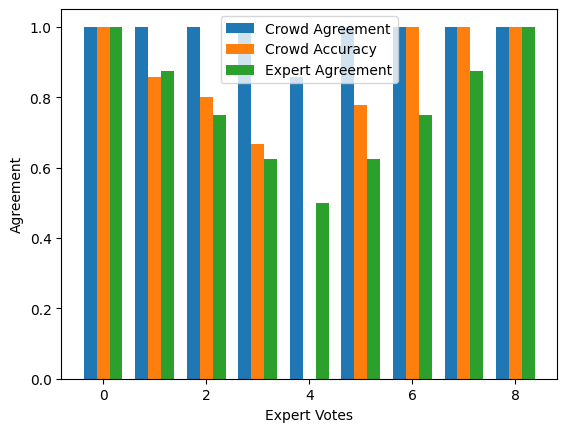

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
w=1/4
ax.bar(agreement_df.index-3/2*w,agreement_df["Crowd Agreement"],w,align='edge',label="Crowd Agreement")
ax.bar(agreement_df.index-w/2,agreement_df["Crowd Accuracy"],w,align='edge',label="Crowd Accuracy")
ax.bar(agreement_df.index+w/2,agreement_df["Expert Agreement"],w,align='edge',label="Expert Agreement")
plt.xlabel("Expert Votes")
plt.ylabel("Agreement")
plt.legend()

The next table shows the percentage of cases of which the crowd accuracy rate is at least as high as the experts. This percentage is 0 for cases where expert agreement is 0.5 because since there's no "correct label" given, we do not have the crowd accuracy rate. For the rest of cases, we can see that when expert agreement rate is 0.625, the crowd had an equal or higher accuracy rate on **57%** of the cases; when expert agreement rate is 0.75, the crowd had an equal or higher accuracy rate on **62%** of the cases; when expert agreement rate is 0.875, the crowd had an equal or higher accuracy rate on **56%** of the cases; when experts are unanimous, the crowd had an equal or higher accuracy rate on **72%** of the cases. From these data, we can conclude that the crowd usually agrees with expert majorities more than experts do. 

In [12]:
df=pd.DataFrame()
df["percentage"]=(1-valid_results["Difficulty"])>=np.max([valid_results["Votes"],8-valid_results["Votes"]],axis=0)/8
df["Expert Agreement"]=np.max([valid_results["Votes"],8-valid_results["Votes"]],axis=0)/8
df.groupby(["Expert Agreement"]).mean()

,percentage
Expert Agreement,
0.500,0.000000
0.625,0.572000
0.750,0.622167
0.875,0.564167
1.000,0.718500


Below is the t-test on whether the mean of crowd accuracy is higher than the experts' accuracy. This result is significant only for cases where number of expert votes is 5 or 6.

In [13]:
d = [1-valid_results.loc[valid_results["Votes"]==i,"Difficulty"] for i in range(9)]
res = stats.ttest_1samp(d,popmean=expert_agreement,axis=1,nan_policy="omit",alternative="greater")
res.pvalue.data < 0.01

array([False, False, False, False, False,  True,  True, False, False])

In [14]:
stats.ttest_1samp(valid_results["Agreement"],popmean=np.mean(expert_agreement),nan_policy="omit",alternative="greater")

Ttest_1sampResult(statistic=103.47184760240071, pvalue=0.0)

Below is the t-test on whether the mean of crowd agreement rate among themselves is higher than the experts. This result is significant for cases where number of expert votes is between 2 and 7.

In [15]:
d = [valid_results.loc[valid_results["Votes"]==i,"Agreement"] for i in range(9)]
res = stats.ttest_1samp(d,popmean=expert_agreement,axis=1,nan_policy="omit",alternative="greater")
res.pvalue.data < 0.01

array([False, False,  True,  True,  True,  True,  True,  True, False])

# Aggregation Methods

In previous analysis, we aggregated the crowd opinion by taking the majority vote. The rates of crowd getting the correct label is shown in the table below.\
In this section, we will try to find other aggregation methods on crowd opinion to get a higher correct rate.

In [16]:
selected_cases=valid_results.loc[~valid_results["Majority Label"].isna() & ~valid_results["Correct Label"].isna(),["Votes","Correct Label", "Majority Label"]]
selected_cases["Correct Rate"]=selected_cases["Correct Label"]==selected_cases["Majority Label"]
agg_mode = selected_cases.groupby("Votes")[["Correct Rate"]].mean()
agg_mode

,Correct Rate
Votes,
0,0.894240
1,0.749831
2,0.699694
3,0.622584
5,0.689112
6,0.813985
7,0.861585
8,0.955034


The first method we try is to weight the crowd labels by the accuracy measure of the labeler. Intuitively, this would mean that if someone has a historically high accuracy rate in labeling images, then when he labels a new image, we would trust his label more than someone who has a low accuracy rate.

In [17]:
agg_w = reads[["problem_id"]]
agg_w["Majority Label"] = reads["chosen_answer"]*reads["accuracy"]
results = agg_w.groupby("problem_id").mean()
results["Majority Label"] = np.sign(results["Majority Label"])
results["Majority Label"].replace([-1,1],["'no'", "'yes'"], inplace=True)

The percentage of correct labels under this aggregation method is in the table below.

In [18]:
agg_w = valid_results[["Votes","Correct Label"]].join(results)
agg_w = agg_w.loc[~valid_results["Majority Label"].isna() & ~valid_results["Correct Label"].isna(),["Votes","Correct Label", "Majority Label"]]
agg_w["Correct Rate"]=agg_w["Correct Label"]==agg_w["Majority Label"]
agg_w = agg_w.groupby("Votes")[["Correct Rate"]].mean()
agg_w

,Correct Rate
Votes,
0,0.895588
1,0.757945
2,0.704120
3,0.612750
5,0.684757
6,0.815657
7,0.862253
8,0.954027


Comparing the result under this new method and result under previous method, we see that there's a slight increase in accuracy rate of the aggregated opinion in most cases. The overall improvement in the accuracy rate is 0.000129.

In [19]:
print(agg_w-agg_mode)
(agg_w-agg_mode).mean()

       Correct Rate
Votes              
0          0.001347
1          0.008114
2          0.004426
3         -0.009834
5         -0.004355
6          0.001673
7          0.000669
8         -0.001007


Correct Rate    0.000129
dtype: float64

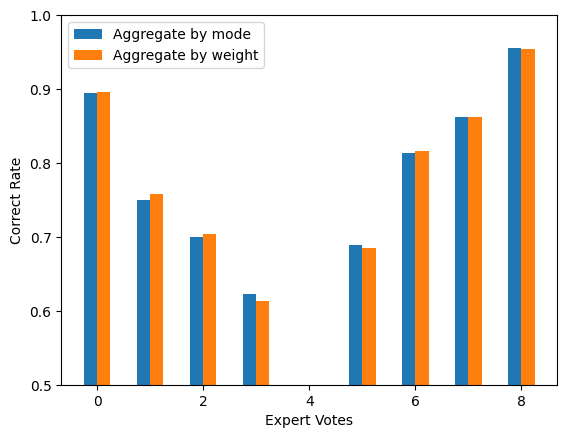

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
w=1/4
ax.bar(agg_mode.index-w,agg_mode["Correct Rate"],w,align='edge',label="Aggregate by mode")
ax.bar(agg_w.index,agg_w["Correct Rate"],w,align='edge',label="Aggregate by weight")
plt.xlabel("Expert Votes")
plt.ylabel("Correct Rate")
plt.ylim([.5,1])
plt.legend()

The next aggregation method we try weights the labels given by labelers by a logistic function as described in the paper **Quality Control of Crowd Labeling through Expert Evaluation**. The new labels given by this aggregation method is shown in the dataframe.

In [21]:
reads.rename(columns={"problem_id":"Case ID"},inplace=True)
agg_l = reads.join(valid_results[["Difficulty", "Correct Label", "Votes"]], on=["Case ID"])
agg_l["Majority Label"] = 1/(1+np.exp(-agg_l["Difficulty"]*(agg_l["accuracy"]-0.5)*2))
agg_l["Majority Label"] = agg_l["Majority Label"]*agg_l["chosen_answer"]
results = agg_l.groupby("Case ID")[["Majority Label"]].mean()
results["Majority Label"] = np.sign(results["Majority Label"])
results["Majority Label"].replace([-1,1],["'no'", "'yes'"], inplace=True)

The new accuracy rates under this aggregation method are shown in the table below.

In [22]:
agg_l = valid_results[["Votes","Correct Label"]].join(results)
agg_l = agg_l.loc[~valid_results["Majority Label"].isna() & ~valid_results["Correct Label"].isna(),["Votes","Correct Label", "Majority Label"]]
agg_l["Correct Rate"]=agg_l["Correct Label"]==agg_l["Majority Label"]
agg_l = agg_l.groupby("Votes")[["Correct Rate"]].mean()
agg_l

,Correct Rate
Votes,
0,0.895925
1,0.758283
2,0.704460
3,0.613767
5,0.685092
6,0.816661
7,0.862253
8,0.954027


By comparing the accuracy rate under this aggregation method and the original aggregation method, we see that the overall accuracy rate improved by 0.000551. This aggregation method gives a slight performance improvement over the previous methods, but the improvement is limited.

In [23]:
print(agg_l-agg_mode)
(agg_l-agg_mode).mean()

       Correct Rate
Votes              
0          0.001684
1          0.008452
2          0.004767
3         -0.008817
5         -0.004020
6          0.002676
7          0.000669
8         -0.001007


Correct Rate    0.000551
dtype: float64

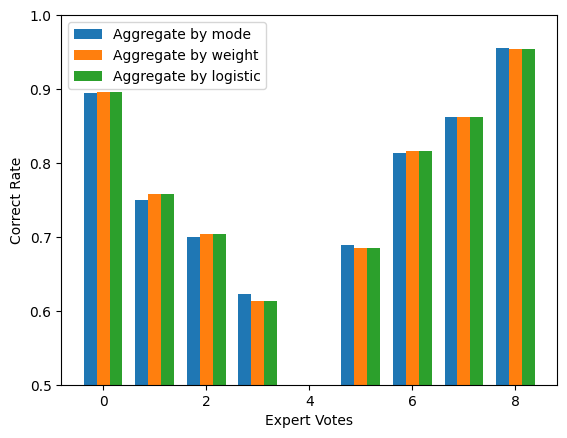

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
w=1/4
ax.bar(agg_mode.index-1.5*w,agg_mode["Correct Rate"],w,align='edge',label="Aggregate by mode")
ax.bar(agg_w.index-0.5*w,agg_w["Correct Rate"],w,align='edge',label="Aggregate by weight")
ax.bar(agg_l.index+0.5*w,agg_l["Correct Rate"],w,align='edge',label="Aggregate by logistic")
plt.xlabel("Expert Votes")
plt.ylabel("Correct Rate")
plt.ylim([.5,1])
plt.legend()